User Settings:

In [1]:
from glob import glob #file regexes

files = glob("*fixed.fepout")
equil = 10000
temperature = 300

Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm #for progress bars
import re #regex
from natsort import natsorted #for sorting "naturally" instead of alphabetically

In [3]:
#Don't work right yet
#from alchemlyb.estimators import BAR 
#from alchemlyb.visualisation.dF_state import plot_dF_state
#from alchemlyb.visualisation import plot_convergence

Function Delcarations:

In [4]:
#redFEPOUT uses reads each file in a single pass: keeping track of lambda values and appending each line to an array. 
#The array is cast to a dataframe at the end to avoid appending to a dataframe
def readFEPOUT(fileName, step=1):
    colNames = ["type",'step', 'Elec_l', 'Elec_ldl', 'vdW_l', 'vdW_ldl', 'dE', 'dE_avg', 'Temp', 'dG', 'FromLambda', "ToLambda"]

    data = []

    L = np.nan
    L2 = np.nan
    LIDWS = np.nan
    
    frame = 0
    with open(fileName) as downFile:
        for line in downFile:
            if line[0] == '#':
                frame = 0
                #print(line)
                Lambda = re.search('LAMBDA SET TO (\d+(\.\d+)*)', line)
                Lambda2 = re.search('LAMBDA2 (\d+(\.\d+)*)', line)
                LambdaIDWS = re.search('LAMBDA_IDWS (\d+(\.\d+)*)', line)
                if Lambda:
                    L = Lambda.group(1)
                    #print(f'L={L}')
                if Lambda2:
                    L2 = Lambda2.group(1)
                    #print(f'L2={L2}')
                if LambdaIDWS:
                    LIDWS = LambdaIDWS.group(1)
                    #print(f'LIDWS={LIDWS}')
            elif frame % step <= 1:
                lineList = line.split()
                lineList.append(L)
                if lineList[0] == "FepEnergy:":
                    lineList.append(L2)
                elif lineList[0] == "FepE_back:":
                    lineList.append(LIDWS)
                else:
                    print(f'Unexpected line start: {lineList[0]}')
                    return 0
                data.append(lineList)
                frame = frame + 1
            else:
                frame = frame + 1

    downFile.close()
    
    df = pd.DataFrame(data).dropna()
    df.columns = colNames
    df = df.iloc[:,1:].astype(float)
    df["window"]=np.mean([df.FromLambda,df.ToLambda], axis=0)
    df["up"]=df.ToLambda>df.FromLambda
   
    df = df.sort_index()
    return df

In [5]:
def readFiles(files, step=1):
    fileList = []
    for file in tqdm(files):
        df = readFEPOUT(file, step)
        fileList.append(df)
    data = pd.concat(fileList)
    
    data.index = data.window
    data["dVdW"] = data.vdW_ldl - data.vdW_l
    
    return data

In [12]:
def u_nk_fromDF(data, temperature):
    from scipy.constants import R, calorie
    beta = 1/(R/(1000*calorie) * temperature) #So that the final result is in kcal/mol
    u_nk = pd.pivot_table(data, index=["step", "FromLambda"], columns="ToLambda", values="dE")
    u_nk = u_nk.sort_index(level=0).sort_index(axis='columns') #sort the data so it can be interpreted by the BAR estimator
    u_nk = u_nk*beta
    #u_nk = u_nk.sort_index(level=1).sort_index(axis='columns') #sort the data so it can be interpreted by the BAR estimator
    
    return u_nk

In [13]:
def get_dG(u_nk):
    #the data frame is organized from index level 1 (fep-lambda) TO column
    #dG will be FROM column TO index
    groups = u_nk.groupby(level=1)
    dG=pd.DataFrame([]) 
    equil = 10000
    for name, group in groups:
        useData = group[group.index.get_level_values(0)>equil]
        dG[name] = np.log(np.mean(np.exp(-1*useData)))
        dG = dG.copy() # this is actually faster than having a fragmented dataframe
        
    return dG

Read files

In [11]:
files = natsorted(files)
data = readFiles(files)

100%|█████████████████████████████████████████████| 1/1 [00:46<00:00, 46.63s/it]


Trim the data to remove pre-equilibration samples

In [14]:

trimmedData = data.loc[data.step>=10000]
u_nk = u_nk_fromDF(trimmedData, temperature)

In [15]:
u_nk.sort_index(level=1)

,ToLambda,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.75,0.80,0.85,0.90,0.95,0.96,0.97,0.98,0.99,1.00
step,FromLambda,,,,,,,,,,,,,,,,,,,,,
10000.0,0.0,NaN,0.083199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10010.0,0.0,NaN,-0.702327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10020.0,0.0,NaN,-1.431156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10030.0,0.0,NaN,-0.550187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10040.0,0.0,NaN,-0.478059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999960.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.094892,NaN
1999970.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.740523,NaN
1999980.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.008739,NaN


In [17]:
dG = get_dG(u_nk)
dG_f=np.diag(dG, k=1)
dG_b=np.diag(dG, k=-1)

l=dG.columns.to_list()
l_mid = np.mean([l[1:],l[:-1]], axis=0)

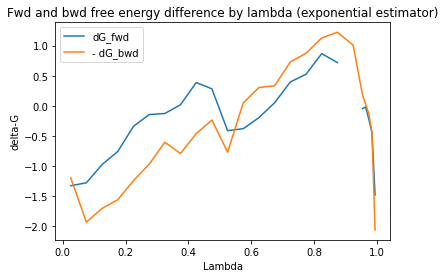

In [18]:
plt.plot(l_mid, dG_f, label='dG_fwd')
plt.plot(l_mid, -dG_b, label='- dG_bwd')

plt.title('Fwd and bwd free energy difference by lambda (exponential estimator)')
plt.xlabel('Lambda')
plt.ylabel('delta-G')
plt.legend()

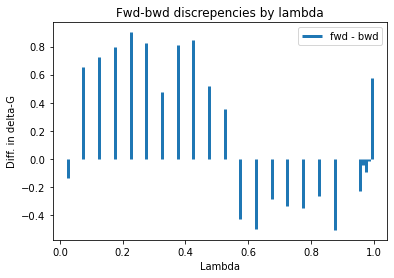

In [19]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=3)

plt.legend()
plt.title('Fwd-bwd discrepencies by lambda')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig("figure.png", dpi=1200)

In [13]:
print(f'The rough estimate for total dG (forward windows only) is: {np.sum(dG_f[~np.isnan(dG_f)])}. The backward estimate is {-np.sum(dG_b[~np.isnan(dG_b)])}')

The rough estimate for total dG (forward windows only) is: -3.034449865439765. The backward estimate is -2.9366115146214007


In [20]:
#split into forward and backward values for each window
backward = data.dE[~(data.up) * data.step>equil].sort_index()*(-1)
forward = data.dE[data.up * data.step>equil].sort_index()
print(f'equilibration Time: {equil}\n backward: {backward.mean()}, forward: {forward.mean()}') 

equilibration Time: 10000
 backward: -0.44868672052261277, forward: 0.023577349266331676


In [15]:
completeWindows = np.sort(list(set(backward.index) & set(forward.index))) #those windows which have both forward and backward data

In [16]:
import seaborn as sns

Plot dE for EACH complete window (may take several minutes)

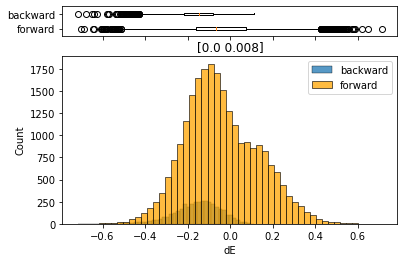

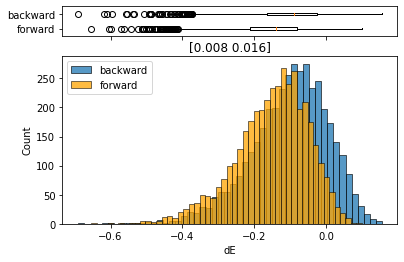

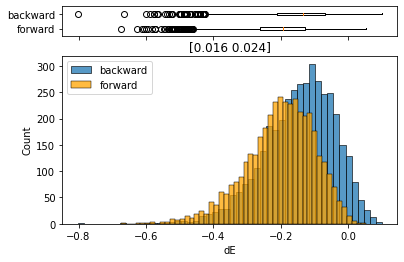

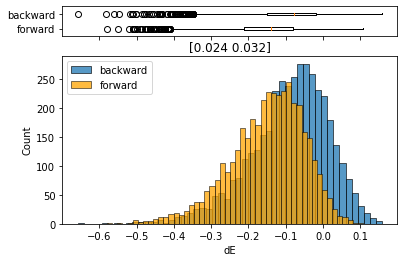

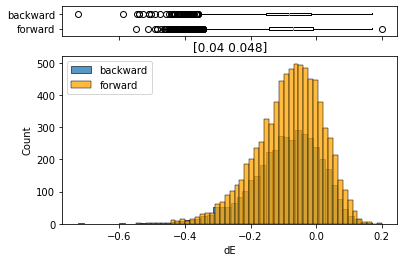

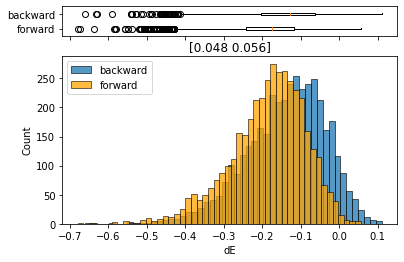

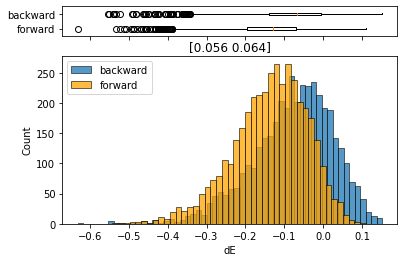

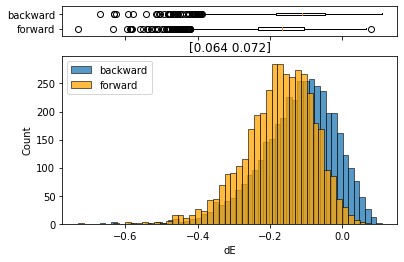

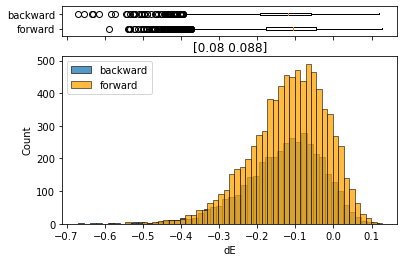

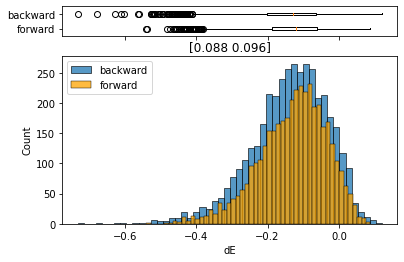

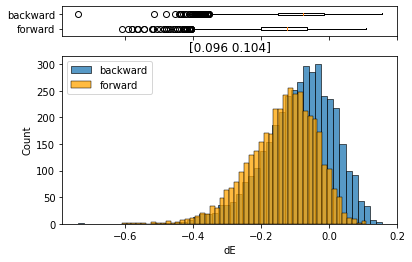

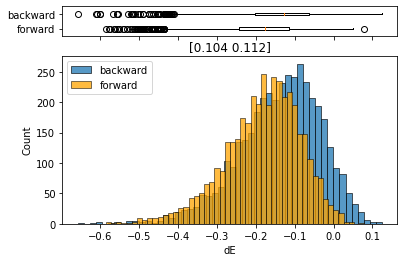

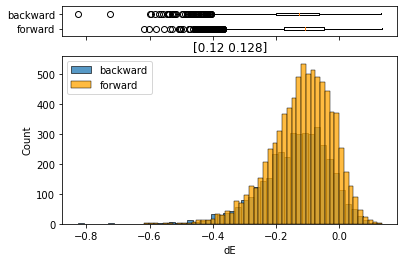

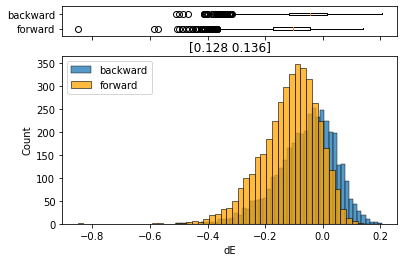

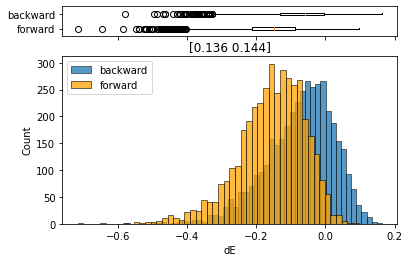

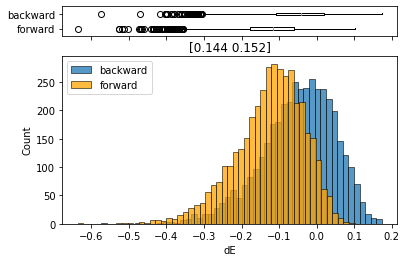

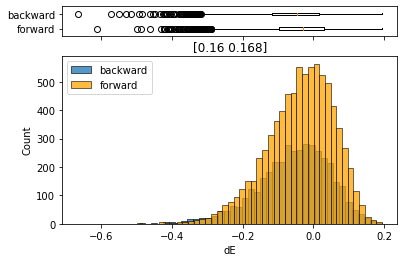

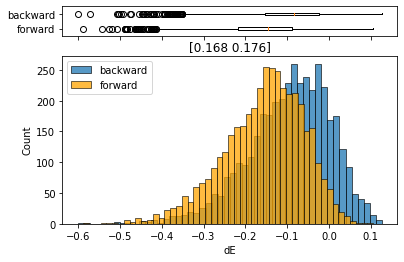

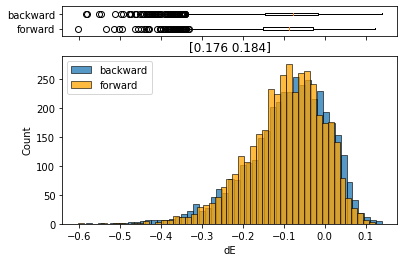

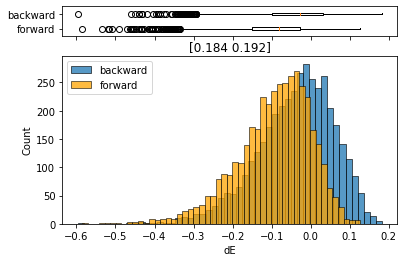

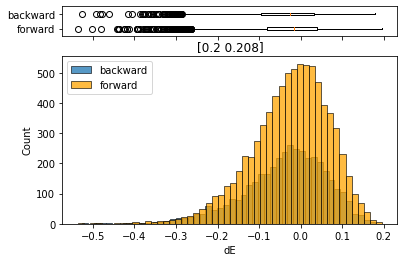

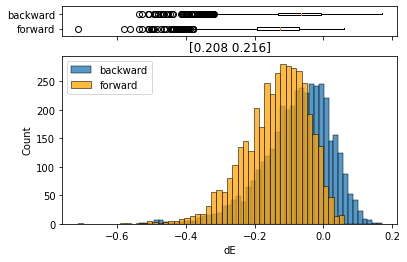

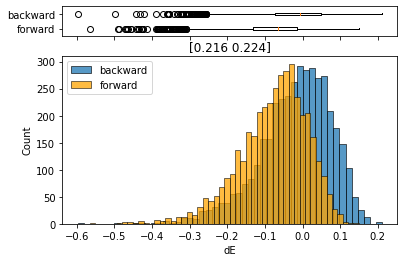

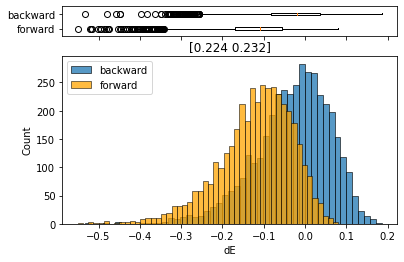

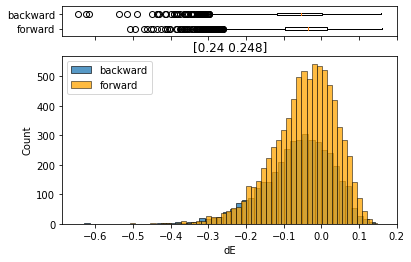

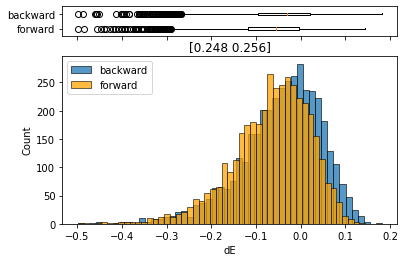

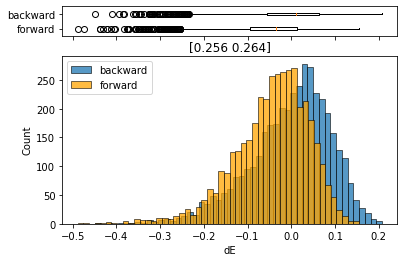

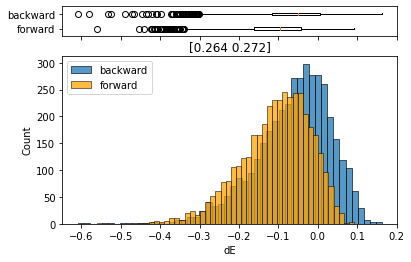

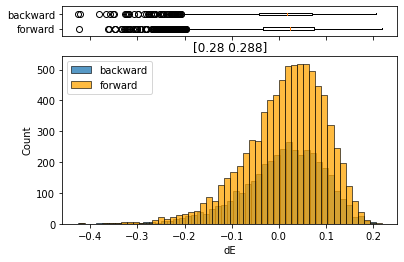

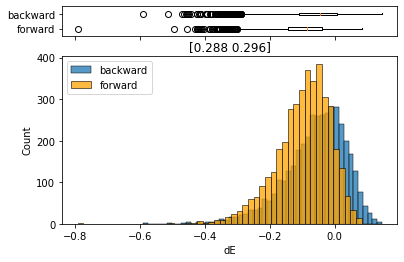

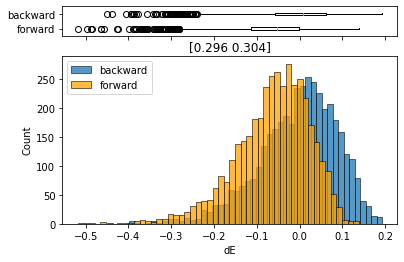

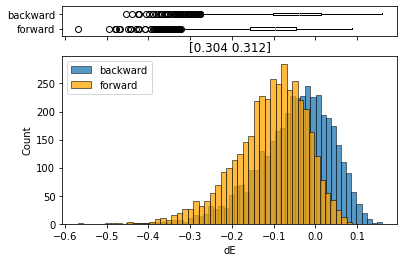

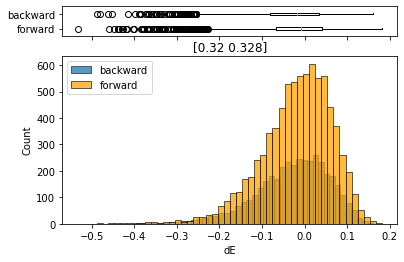

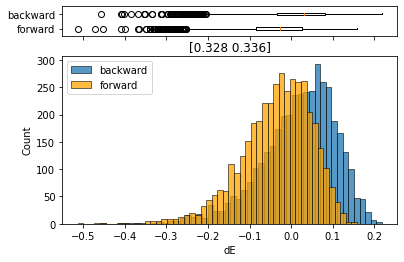

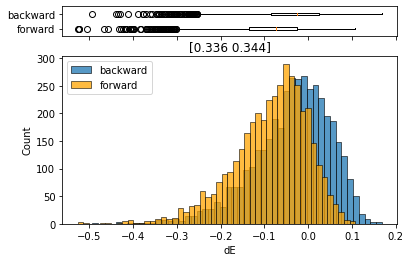

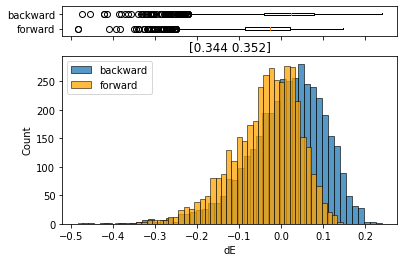

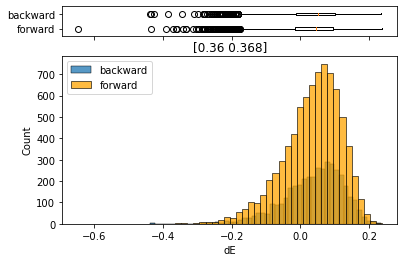

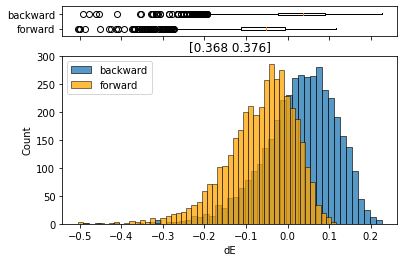

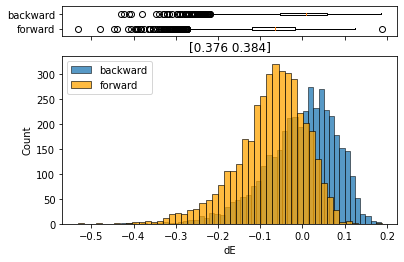

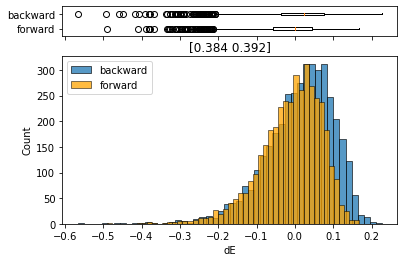

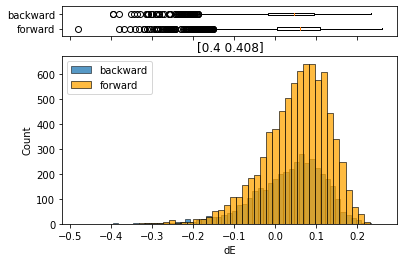

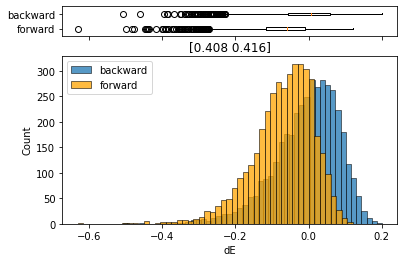

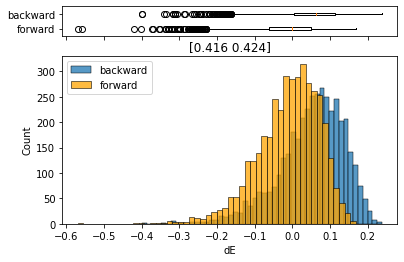

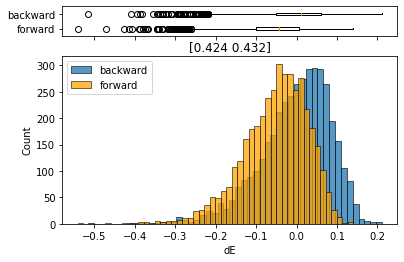

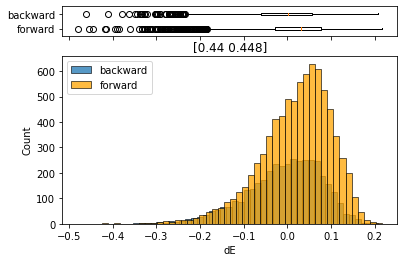

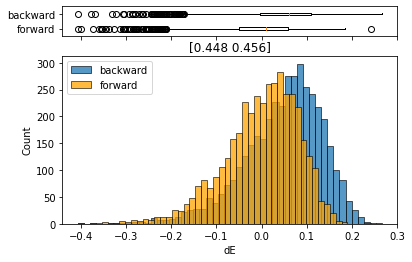

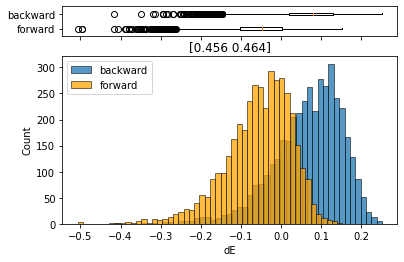

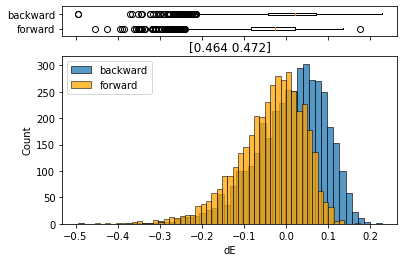

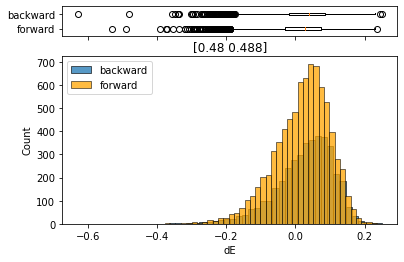

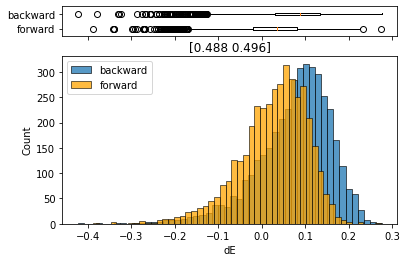

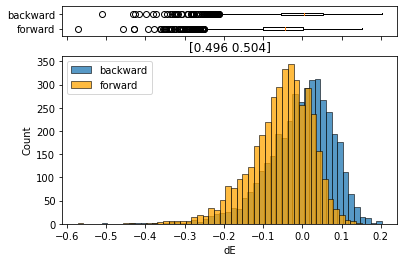

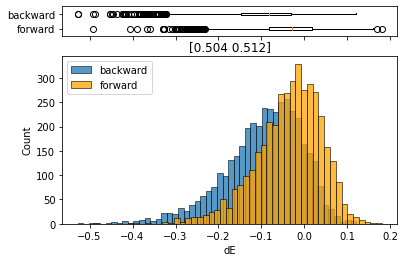

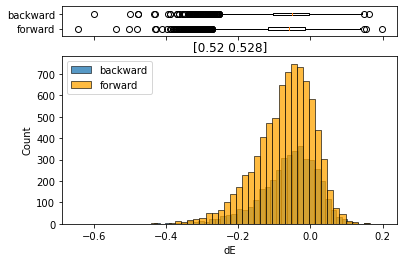

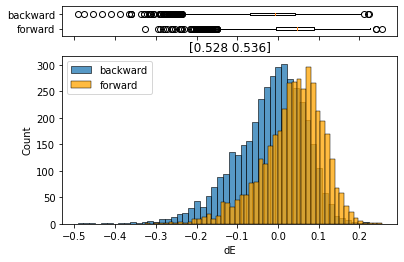

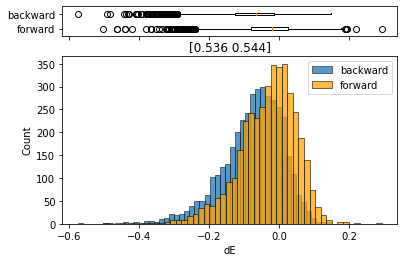

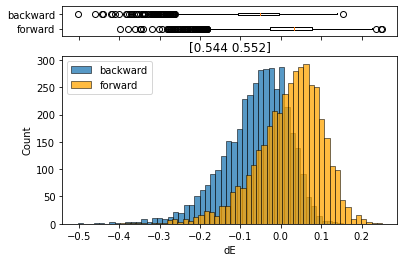

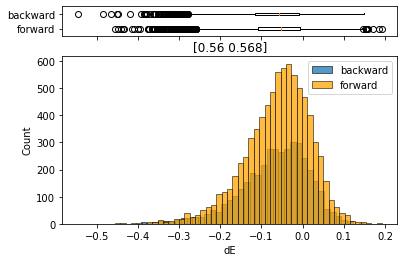

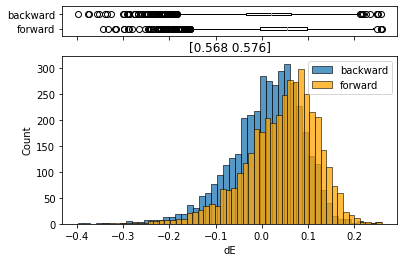

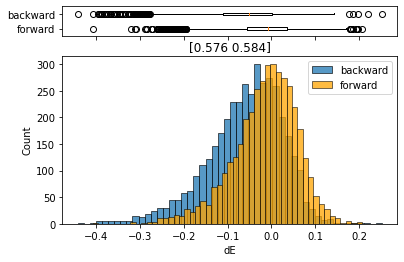

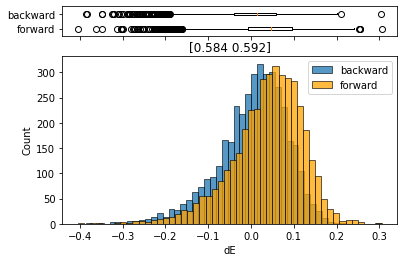

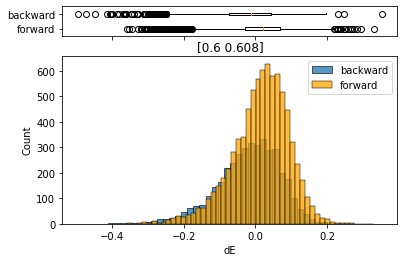

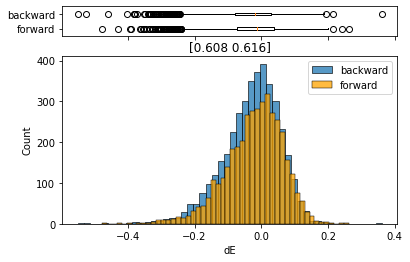

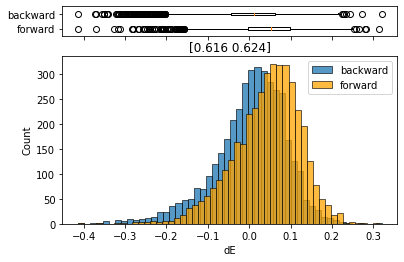

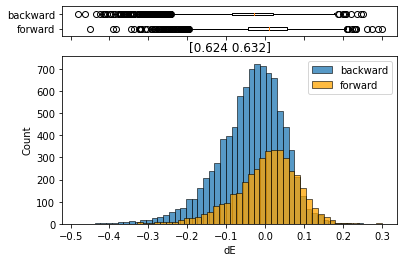

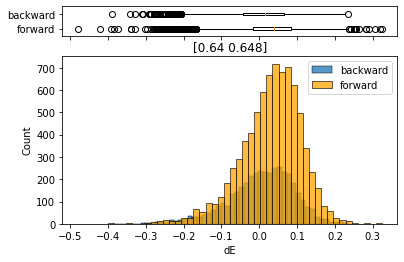

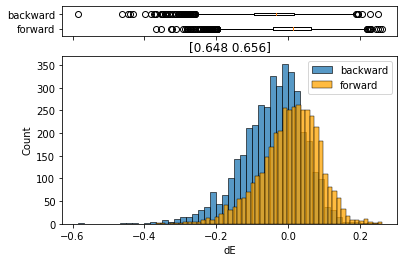

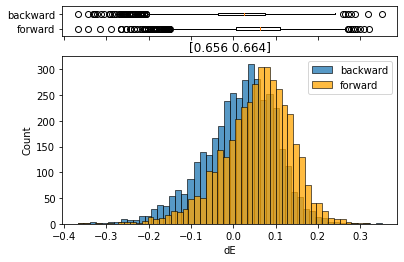

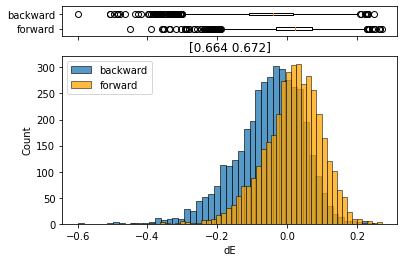

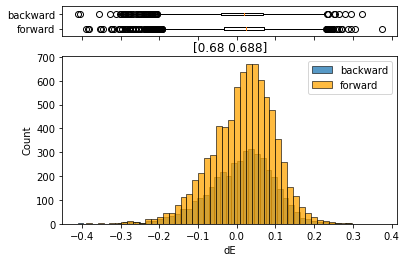

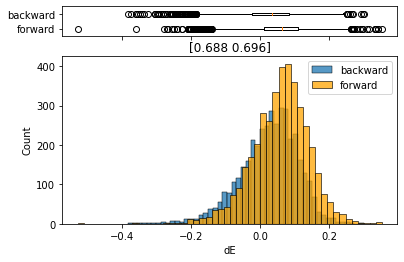

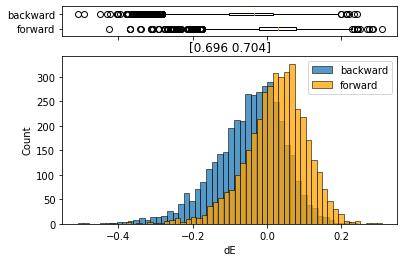

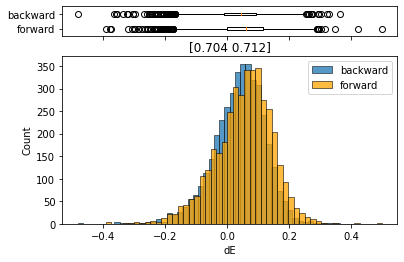

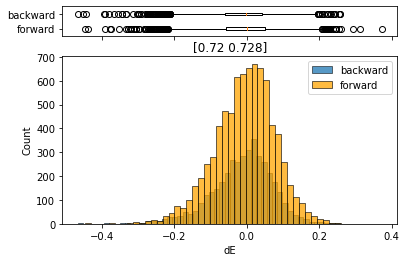

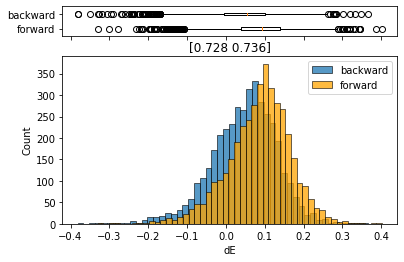

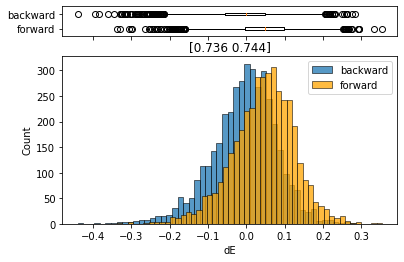

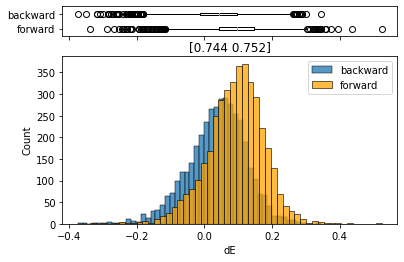

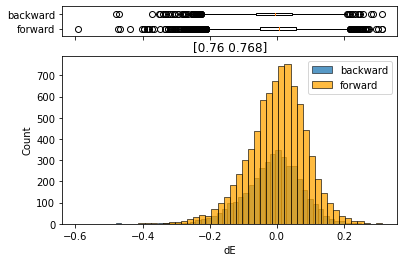

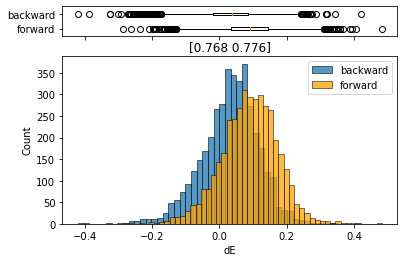

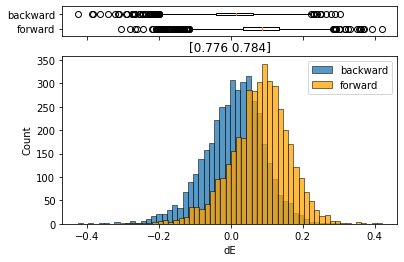

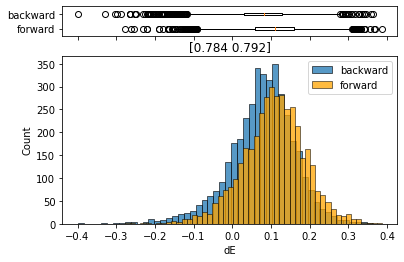

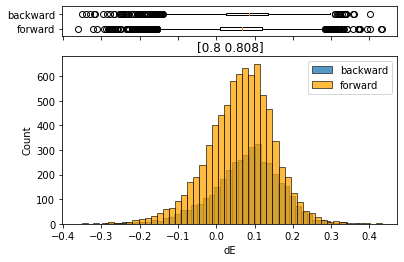

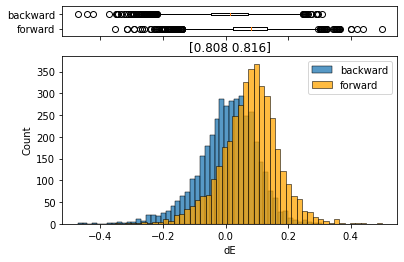

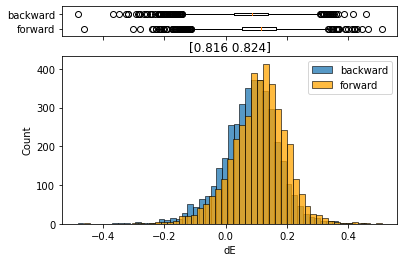

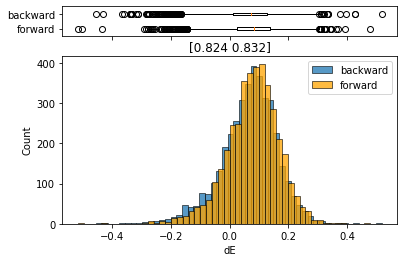

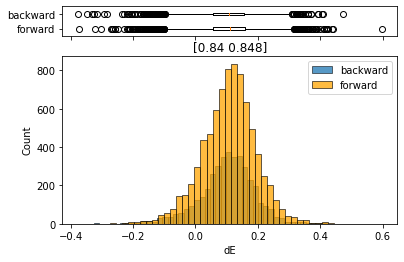

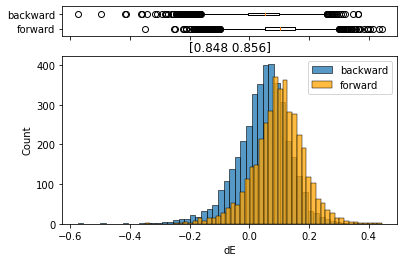

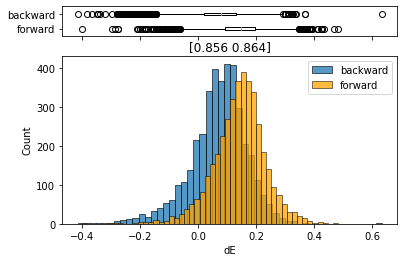

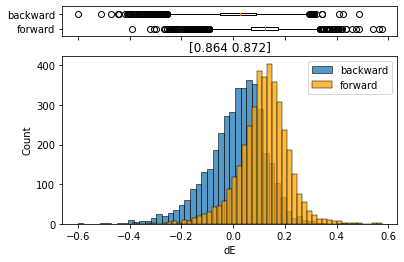

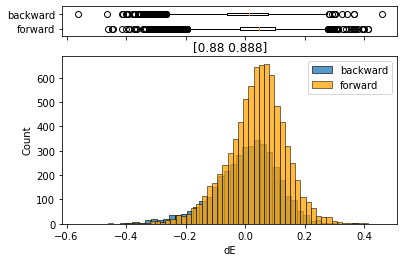

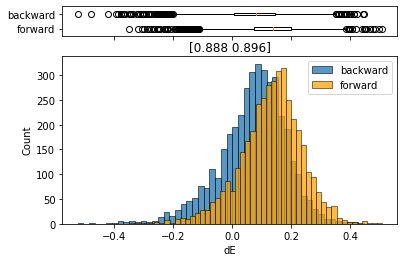

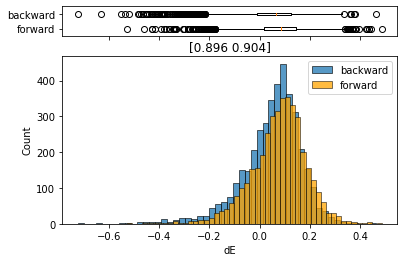

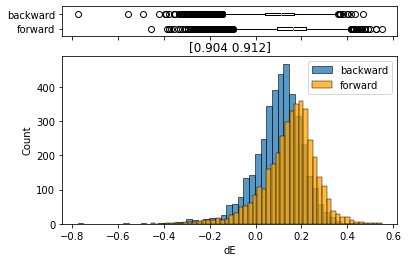

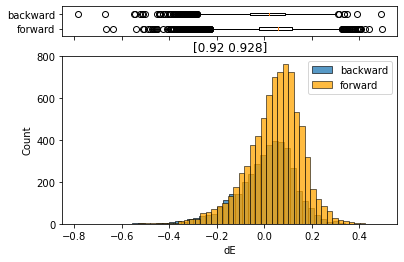

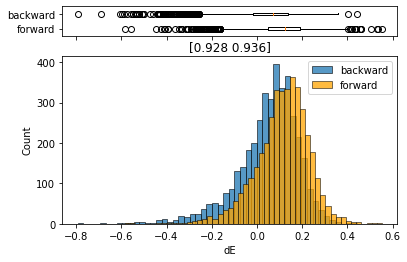

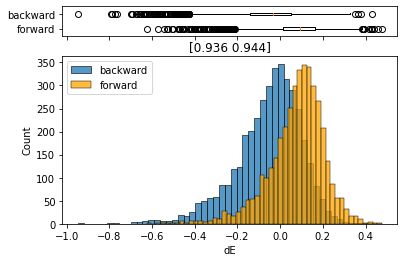

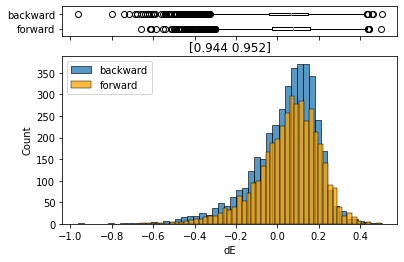

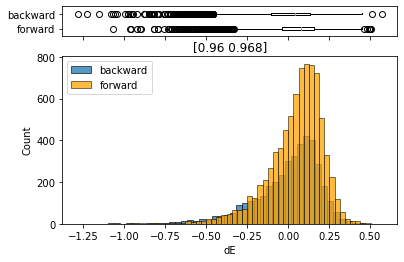

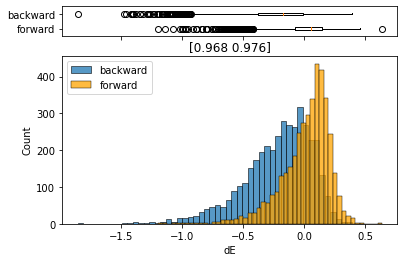

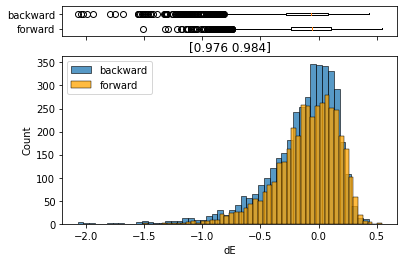

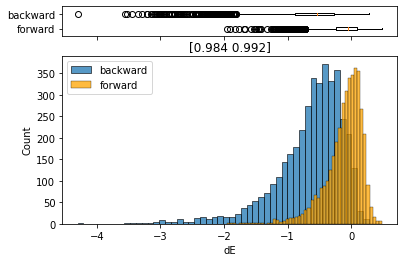

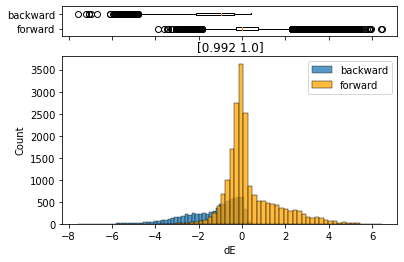

In [17]:
for i in completeWindows:
    
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # assigning a graph to each ax
    tempDat = [forward.loc[i], backward.loc[i]]
    
    ax_box.boxplot(tempDat, vert=False)
    ax_box.set_yticklabels(["forward", "backward"])
    plt.title(f'[{np.round(i-0.004,3)} {np.round(i+0.004, 3)}]')
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

    sns.histplot(backward.loc[i], bins=50, label="backward", ax=ax_hist);
    sns.histplot(forward.loc[i], bins=50, label="forward", ax=ax_hist, color="orange");
    
    plt.legend()
    plt.show()
    #plt.savefig(f'./diagnosticPlots/dE_SmallerWindows{np.round(i,3)}.svg')
    plt.clf()
    plt.close()